# Diffusion unet

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.training import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b):
    img = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

## Basic autoencoder

In [ ]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

class ResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.conv1 = unet_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = unet_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x): return self.conv2(self.conv1(x)) + self.idconv(x)

def down_block(ni, nf, down=True, num_layers=1):
    res = nn.Sequential(*[ResBlock(ni if i==0 else nf, nf) for i in range(num_layers)])
    if down: res.append(nn.Conv2d(nf, nf, 3, stride=2, padding=1))
    return res

def up_block(ni, nf, up=True, num_layers=1):
    res = nn.Sequential(*[ResBlock(ni if i==0 else nf, nf) for i in range(num_layers)])
    if up: res.append(upsample(nf))
    return res

In [ ]:
class Autoencoder(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(4,8,12,12), num_layers=2):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=5, padding=2)
        n = len(nfs)
        self.downs = nn.Sequential(*[down_block(nfs[i-1], nfs[i], num_layers=num_layers) for i in range(1,n)])
        rev_nfs = list(reversed(nfs))
        self.ups = nn.Sequential(*[up_block(rev_nfs[i], rev_nfs[i+1], num_layers=num_layers+1) for i in range(n-1)])
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, x):
        x = self.conv_in(x)
        x = self.downs(x)
        x = self.ups(x)
        x = self.conv_out(x)
        return (x.sigmoid()*3)-1.5
#         return x

In [ ]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = Autoencoder(in_channels=1, out_channels=1)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.440,0,train
0.223,0,eval
0.111,1,train
0.062,1,eval
0.047,2,train
0.043,2,eval
0.039,3,train
0.039,3,eval
0.035,4,train
0.039,4,eval


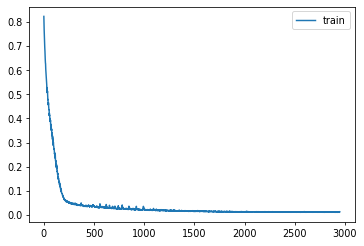

In [ ]:
learn.fit(epochs)

## Sample

In [ ]:
dl = dls.valid
xb,yb = b = next(iter(dl))

In [ ]:
t = to_cpu(model(xb.cuda())).clamp(-1,1)

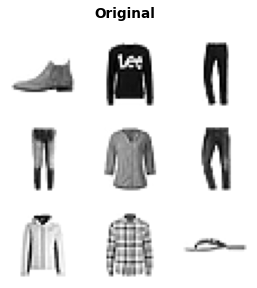

In [ ]:
show_images(xb[:9], imsize=1.5, title='Original');

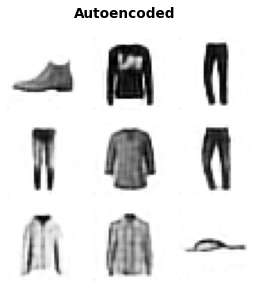

In [ ]:
show_images(t[:9], imsize=1.5, title='Autoencoded');